# Exploring the Walk-Forward-Validation Strategy + Hypertuning
### Experiments with Tree-based Scikit-learn models

**Objective**: The primary objective of this notebook is to analyze the results of the tree-based models for multi-step ahead forecasting.

## 1.0 Imports

In [1]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Move up one level to the project root
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Change working directory
os.chdir(project_root)

# Verify the change
print(os.getcwd()) 

/home/michel/projects/tree-based-forecasting-boilerplate


In [2]:
%load_ext autoreload
%autoreload 2

from scripts.run_wfv import *
from src.models.train_model import *
from src.models.evaluate_model import *
from src.models.predict_model import *
from src.visualization.data_viz import *

## 2.0 Data Reading

In [7]:
OUTPUT_DATA_PATH

'data/output'

In [40]:
ticker = 'EGIE3.SA'

feature_df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, PROCESSED_DATA_NAME), parse_dates=["DATE"])
wfv_results_default = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, 'default_validation_results.csv'), parse_dates=["DATE"])
wfv_results_tuned = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, 'validation_results.csv'), parse_dates=["DATE"])

cv_results_ada = pd.read_csv(os.path.join(f'./models/{ticker}', 'cv_results_ADA.csv'))
cv_results_et = pd.read_csv(os.path.join(f'./models/{ticker}', 'cv_results_ET.csv'))
cv_results_xgb = pd.read_csv(os.path.join(f'./models/{ticker}', 'cv_results_XGB.csv'))

## 3.0 Analysing the forecasting performance for one ticker: EGIE3.SA

In [41]:
feature_df = feature_df[feature_df['TICKER'] == ticker]
wfv_results_default = wfv_results_default[wfv_results_default['TICKER'] == ticker]
wfv_results_tuned = wfv_results_tuned[wfv_results_tuned['TICKER'] == ticker]

In [50]:
cv_results_ada

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_learning_rate,param_loss,param_n_estimators,param_random_state,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.266067,0.023405,0.018217,0.008674,DecisionTreeRegressor(max_depth=1),1.00,linear,40,42,{'estimator': DecisionTreeRegressor(max_depth=...,...,-3.548568,-3.968140,-3.773481,0.172620,612,-1.277738,-1.280953,-1.321282,-1.293324,0.019812
1,0.328440,0.079060,0.023976,0.007899,DecisionTreeRegressor(max_depth=1),1.00,linear,50,42,{'estimator': DecisionTreeRegressor(max_depth=...,...,-3.548568,-3.968140,-3.773481,0.172620,612,-1.262646,-1.216776,-1.283156,-1.254193,0.027751
2,0.511399,0.069330,0.031812,0.009304,DecisionTreeRegressor(max_depth=1),1.00,linear,80,42,{'estimator': DecisionTreeRegressor(max_depth=...,...,-3.548568,-4.001156,-3.784487,0.185269,619,-1.197424,-1.195746,-1.247990,-1.213720,0.024242
3,0.632425,0.079234,0.036678,0.010432,DecisionTreeRegressor(max_depth=1),1.00,linear,100,42,{'estimator': DecisionTreeRegressor(max_depth=...,...,-4.257767,-4.001156,-4.020886,0.185881,627,-1.185551,-1.189765,-1.196447,-1.190588,0.004487
4,0.936291,0.154365,0.066310,0.008930,DecisionTreeRegressor(max_depth=1),1.00,linear,150,42,{'estimator': DecisionTreeRegressor(max_depth=...,...,-4.257767,-4.001156,-4.231301,0.178094,630,-1.155448,-1.171655,-1.113403,-1.146835,0.024549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,161.856729,20.093129,1.595081,0.238728,RandomForestRegressor(n_estimators=70),0.01,exponential,40,42,{'estimator': RandomForestRegressor(n_estimato...,...,-0.338800,-0.217137,-0.289219,0.052155,344,-0.151439,-0.149361,-0.149662,-0.150154,0.000917
626,178.566598,45.653645,0.582334,0.043344,RandomForestRegressor(n_estimators=70),0.01,exponential,50,42,{'estimator': RandomForestRegressor(n_estimato...,...,-0.328096,-0.215535,-0.287864,0.051252,340,-0.148639,-0.147131,-0.149147,-0.148305,0.000856
627,98.200051,7.883591,0.967316,0.053553,RandomForestRegressor(n_estimators=70),0.01,exponential,80,42,{'estimator': RandomForestRegressor(n_estimato...,...,-0.333651,-0.207837,-0.284782,0.055067,317,-0.146106,-0.144929,-0.145774,-0.145603,0.000496
628,116.860923,11.132218,0.919360,0.130071,RandomForestRegressor(n_estimators=70),0.01,exponential,100,42,{'estimator': RandomForestRegressor(n_estimato...,...,-0.321661,-0.206104,-0.281521,0.053365,271,-0.144950,-0.144101,-0.145036,-0.144696,0.000422


In [43]:
wfv_results_tuned.sample(5)

,DATE,ACTUAL,FORECAST,MODEL_TYPE,TRAINING_MAPE,TRAINING_RMSE,TICKER,MAPE,RMSE,Bias,CLASS,TRAINING_DATE
533,2024-06-18,43.86,43.347363,XGBRegressor,0.0020,0.09,EGIE3.SA,0.0077,0.36,-0.006,Testing,2024-07-10
596,2024-06-28,44.29,43.954076,ExtraTreesRegressor,0.0099,0.48,EGIE3.SA,0.0147,0.75,-0.004,Testing,2024-07-10
585,2024-06-13,43.61,43.645179,ExtraTreesRegressor,0.0100,0.48,EGIE3.SA,0.0043,0.25,0.000,Testing,2024-07-10
634,2024-06-05,43.80,43.800000,AdaBoostRegressor,0.0095,0.42,EGIE3.SA,0.0062,0.33,-0.000,Testing,2024-07-10
639,2024-06-12,43.47,43.913667,AdaBoostRegressor,0.0096,0.42,EGIE3.SA,0.0080,0.37,0.005,Testing,2024-07-10


In [44]:
default_metrics = wfv_results_default.groupby("TICKER").agg({"RMSE": "mean", "MAPE": "mean", "TRAINING_MAPE": "mean", "TRAINING_RMSE": "mean"})
default_metrics.sort_values("RMSE")

,RMSE,MAPE,TRAINING_MAPE,TRAINING_RMSE
TICKER,,,,
EGIE3.SA,0.888485,0.018739,0.004482,0.204848


In [45]:
tuned_metrics = wfv_results_tuned.groupby("TICKER").agg({"RMSE": "mean", "MAPE": "mean", "TRAINING_MAPE": "mean", "TRAINING_RMSE": "mean"})
tuned_metrics.sort_values("RMSE")

,RMSE,MAPE,TRAINING_MAPE,TRAINING_RMSE
TICKER,,,,
EGIE3.SA,0.748485,0.0156,0.007167,0.330909


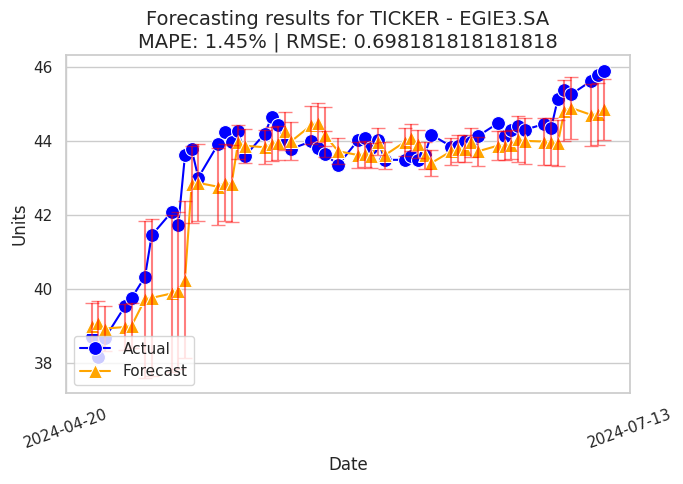

In [49]:
visualize_validation_results(wfv_results_default[wfv_results_default["MODEL_TYPE"] == 'ExtraTreesRegressor'], ticker)

In [21]:
pred_df = wfv_results_default[(wfv_results_default["MODEL_TYPE"] == 'AdaBoostRegressor')]

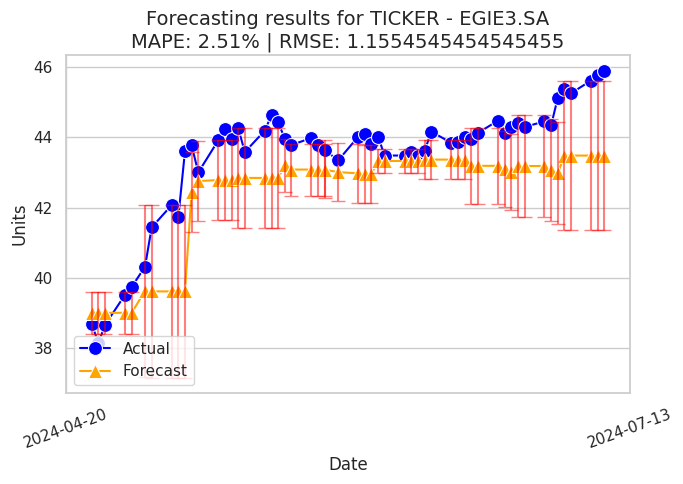

In [22]:
visualize_validation_results(pred_df, ticker)

## 4.0 Analyzing Hyperparameter tuning results

In [30]:
param_columns = [col for col in cv_results_ada.columns if 'param_' in col]
test_score_col = 'mean_test_score'
train_score_col = 'mean_train_score'
print(param_columns)

['param_estimator', 'param_learning_rate', 'param_loss', 'param_n_estimators', 'param_random_state']


In [31]:
cv_results_ada[param_columns]

,param_estimator,param_learning_rate,param_loss,param_n_estimators,param_random_state
0,DecisionTreeRegressor(max_depth=1),1.00,linear,40,42
1,DecisionTreeRegressor(max_depth=1),1.00,linear,50,42
2,DecisionTreeRegressor(max_depth=1),1.00,linear,80,42
3,DecisionTreeRegressor(max_depth=1),1.00,linear,100,42
4,DecisionTreeRegressor(max_depth=1),1.00,linear,150,42
...,...,...,...,...,...
625,RandomForestRegressor(n_estimators=70),0.01,exponential,40,42
626,RandomForestRegressor(n_estimators=70),0.01,exponential,50,42
627,RandomForestRegressor(n_estimators=70),0.01,exponential,80,42
628,RandomForestRegressor(n_estimators=70),0.01,exponential,100,42


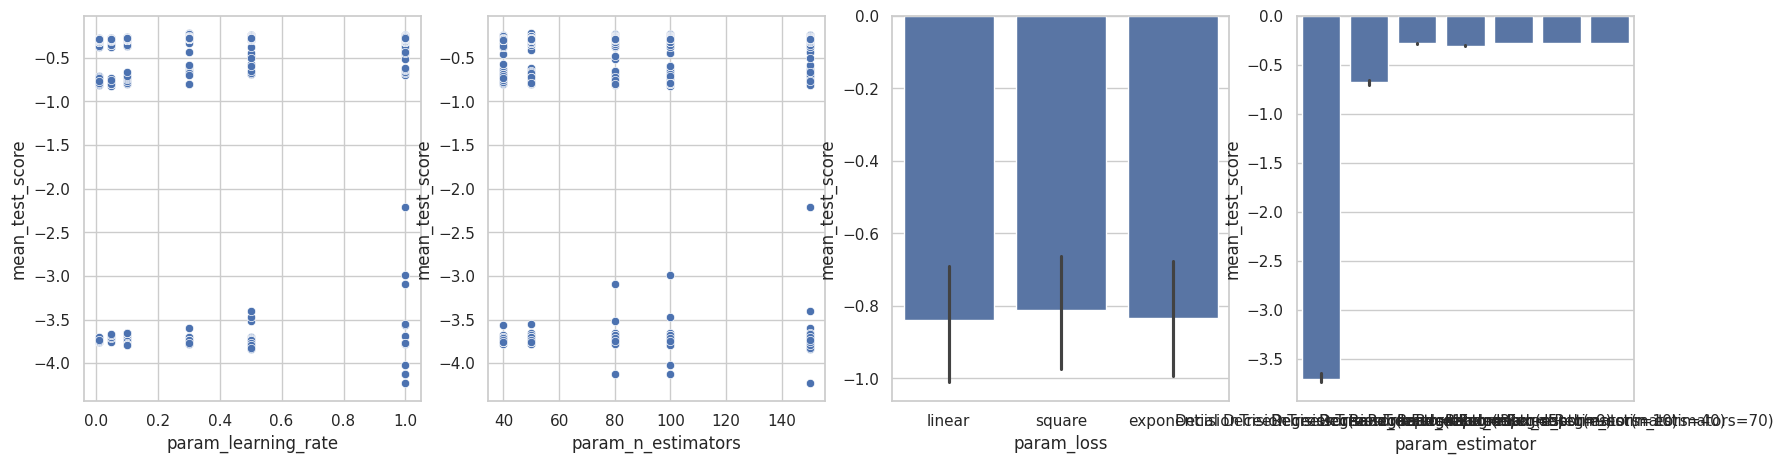

In [37]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
sns.scatterplot(data=cv_results_ada, x='param_learning_rate', y=test_score_col, ax=axs[0])
sns.scatterplot(data=cv_results_ada, x='param_n_estimators', y=test_score_col, ax=axs[1])
sns.barplot(data=cv_results_ada, x='param_loss', y=test_score_col, ax=axs[2])
sns.barplot(data=cv_results_ada, x='param_estimator', y=test_score_col, ax=axs[3])
plt.show()